In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imp import reload

from cca import ComplexityComponentsAnalysis as CCA
from cca import methods_comparison as mc
from cca import synth_data

# Comparison with PCA

If the dimensions with dynamics have low variance compared to the noise dimensions, PCA will not recover the dynamics.

Here, we test this on a dataset where the first two dimensions are GPs with different kernels and kernel parameters and variance=1. The second two dimensions are multivariate noise with variances 5 and 2 respectively.

In [2]:
n_samples = 1000
GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=3., local_noise=.01)
X1 = synth_data.sample_gp(n_samples, 1, GP_ker)
GP_ker = synth_data.gen_gp_kernel('exp', spatial_scale=2., temporal_scale=5., local_noise=.01)
X2 = synth_data.sample_gp(n_samples, 1, GP_ker)
X3 = np.random.multivariate_normal([0., 0.], [[5., 0.], [0., 2]], size=n_samples)
X = np.concatenate([X1, X2, X3], axis=1)

In [3]:
pca = PCA(n_components=2).fit(X)
print(pca.components_.T)

[[-0.04236146  0.0500153 ]
 [-0.00483854  0.04384511]
 [ 0.99867836 -0.02632921]
 [ 0.0286988   0.99743814]]


In [5]:
cca = CCA(d=1, T=5, n_init=5).fit(X)
print(cca.coef_)

cca = CCA(d=2, T=5, n_init=5).fit(X)
print(cca.coef_)

[[ 9.99998321e-01]
 [-1.08501259e-03]
 [-1.25290574e-03]
 [ 7.81898174e-04]]
[[ 0.90701203  0.42110095]
 [-0.42109126  0.90698449]
 [-0.00269863  0.00243586]
 [-0.00201019  0.00686916]]


# Comparison to SFA
SFA is only sensitive to the autocorrelation at one time-lag wheras DCA is sensitive to all auto and crosscorrelations at up to 2T time-lags.

In [2]:
T = 50
noise = .0001
taus = np.linspace(.9, 1., 100)
gauss_pi = np.zeros_like(taus)
exp_pi = np.zeros_like(taus)
gauss_ac1 = np.zeros_like(taus)
exp_ac1 = np.zeros_like(taus)

In [3]:
for ii, tau in enumerate(taus):
    gauss_k = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
    exp_k = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
    gauss_cov = synth_data.gen_gp_cov(T, 1, gauss_k)
    exp_cov = synth_data.gen_gp_cov(T, 1, exp_k)
    gauss_ac1[ii] = gauss_cov[0, 1]
    exp_ac1[ii] = exp_cov[0, 1]
    gauss_pi[ii] = synth_data.calc_pi_for_gp(T, 1, gauss_k)
    exp_pi[ii] = synth_data.calc_pi_for_gp(T, 1, exp_k)

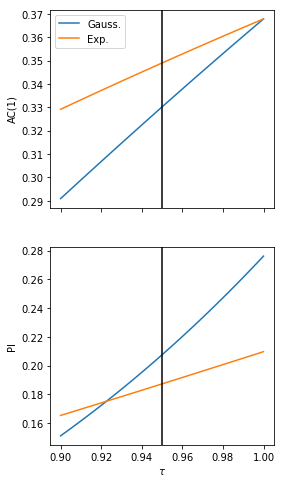

In [4]:
tau = .95
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 8))
ax1.plot(taus, gauss_ac1, label='Gauss.')
ax1.plot(taus, exp_ac1, label='Exp.')
ax1.set_ylabel('AC(1)')
ax1.axvline(tau, 0, 1, c='k')
ax1.legend(loc='best')

ax2.plot(taus, gauss_pi)
ax2.plot(taus, exp_pi)
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel('PI')
ax2.axvline(tau, 0, 1, c='k')

In [10]:
n_samples = 1000
GP1_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
GP2_ker = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
X1 = synth_data.sample_gp(n_samples, 1, GP1_ker, num_to_concat=10) * 2.
X2 = synth_data.sample_gp(n_samples, 1, GP2_ker, num_to_concat=10)
#X2 = np.random.randn(n_samples, 1)
X = np.concatenate([X1, X2], axis=1)

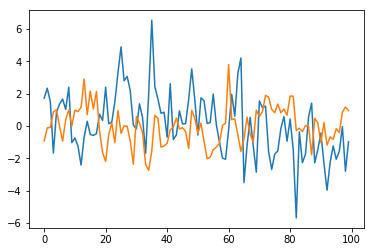

In [11]:
plt.plot(X1[:100])
plt.plot(X2[:100])

In [12]:
reload(mc)
sfa_model = mc.SlowFeatureAnalysis(1).fit(X)
print(sfa_model.coef_)

[[-0.01350397]
 [-0.99990882]]


In [13]:
cca_model = CCA(d=1, T=1, n_init=5).fit(X)
print(cca_model.coef_)

[[-0.01163168]
 [-0.99993235]]


In [19]:
cca_model = CCA(d=1, T=2, n_init=5).fit(X)
print(cca_model.coef_)

[[0.99559477]
 [0.09376066]]


# Comparison with GPFA

In [20]:
n_samples = 1000
GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=3., local_noise=.01)
X1 = synth_data.sample_gp(n_samples, 1, GP_ker)
GP_ker = synth_data.gen_gp_kernel('exp', spatial_scale=2., temporal_scale=5., local_noise=.01)
X2 = synth_data.sample_gp(n_samples, 1, GP_ker)
X3 = np.random.multivariate_normal([0., 0.], [[5., 0.], [0., 2]], size=n_samples)
X = np.concatenate([X1, X2, X3], axis=1)

In [137]:
reload(mc)

gpfa = mc.GaussianProcessFactorAnalysis(n_factors=2, verbose=True)
gpfa.fit(X)

log likelihood: -8190.730619794056
log likelihood: -8190.730619794056
log likelihood: -18663.24654725548


KeyboardInterrupt: 

In [130]:
def log_likelihood(mu, sigma, y):
    """Log likelihood for a multivariate normal distribution.

    Only works for 1 sample data.
    """
    d = y.size
    log_det_cov = np.linalg.slogdet(sigma)[1]
    y_minus_mean = y - mu
    cov_y = np.dot(y_minus_mean.T, y_minus_mean)
    log_likelihood = (-0.5*d*np.log(2*np.pi)
                      - 0.5*log_det_cov
                      - 0.5*np.trace(np.linalg.solve(sigma, cov_y)))
    return log_likelihood

def log_likelihood2(mu, sigma, y):
    """Log likelihood for a multivariate normal distribution.

    Only works for 1 sample data.
    """
    d = y.size
    log_det_cov = np.linalg.slogdet(sigma)[1]
    y_minus_mean = y - mu
    term3 = np.dot(y_minus_mean.T.ravel(), np.linalg.solve(sigma, y_minus_mean.T).ravel())
    log_likelihood = (-0.5*d*np.log(2*np.pi)
                      - 0.5*log_det_cov
                      - 0.5*term3)
    return log_likelihood

def log_likelihood3(mu, sigma, y):
    """Log likelihood for a multivariate normal distribution.

    Only works for 1 sample data.
    """
    d = y.size
    log_det_cov = np.linalg.slogdet(sigma)[1]
    y_minus_mean = y - mu
    term3 = np.sum(y_minus_mean.T *np.linalg.solve(sigma, y_minus_mean.T).ravel())
    log_likelihood = (-0.5*d*np.log(2*np.pi)
                      - 0.5*log_det_cov
                      - 0.5*term3)
    return log_likelihood

In [131]:
mu = np.random.randn(1, 1000)
sigma = np.cov(np.random.randn(2000, 1000), rowvar=False)
y = np.random.randn(1, 1000)

In [132]:
sigma.shape

(1000, 1000)

In [133]:
log_likelihood2(mu, sigma, y)

-2747.8469478874435

In [134]:
log_likelihood3(mu, sigma, y)

-4832.43711966604

In [135]:
%timeit log_likelihood2(mu, sigma, y)

11 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [136]:
%timeit log_likelihood3(mu, sigma, y)

12.1 ms ± 45.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


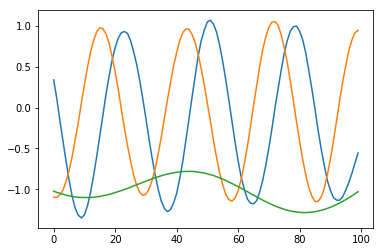

In [23]:
for x in gpfa.transform(X).T:
    plt.plot(x)
plt.show()

In [24]:
gpfa.tau_

array([ 7.81299041,  7.99692801, 23.92925725])

# SFA

In [81]:
t = np.linspace(0, 200, 10000)
x = np.stack([np.sin(.25 * t), np.cos(t)]).T
y = x.dot(stats.ortho_group.rvs(4)[:2])
y += np.random.randn(*y.shape) / 4.
y -= y.mean(axis=0, keepdims=True)

In [82]:
y.shape

(10000, 4)

In [83]:
u, s, vh = np.linalg.svd(y)
whiten = vh.T.dot(np.diag(1./s))
yw = y.dot(whiten)
yp = np.diff(yw, axis=0)

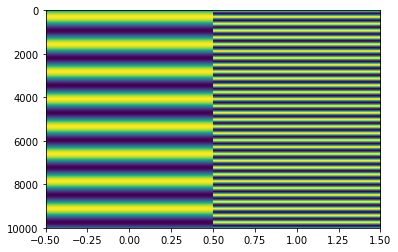

In [84]:
plt.imshow(x, aspect='auto')
plt.show()

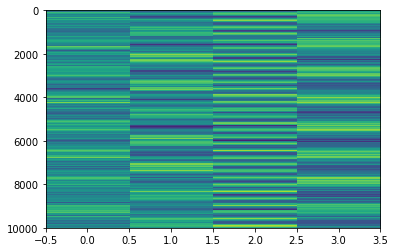

In [85]:
plt.imshow(y, aspect='auto')
plt.show()

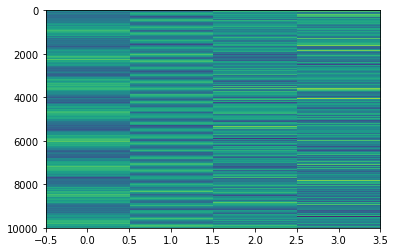

In [86]:
plt.imshow(yw, aspect='auto')
plt.show()

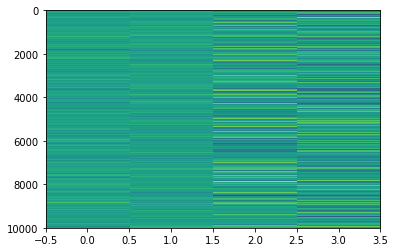

In [87]:
plt.imshow(yp, aspect='auto')
plt.show()

In [88]:
u, s, vh = np.linalg.svd(yp, full_matrices=False)
proj = vh.T

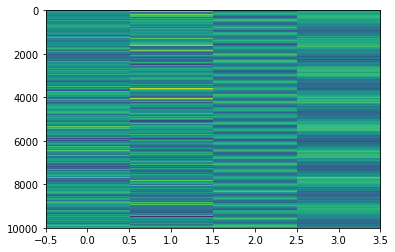

In [89]:
y_proj = y.dot(whiten.dot(proj))
plt.imshow(y_proj, aspect='auto')
plt.show()

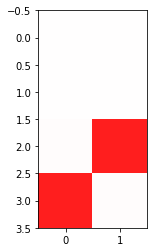

In [90]:
y_norm = y_proj - y_proj.mean(axis=0, keepdims=True)
y_norm /= np.linalg.norm(y_norm, axis=0, keepdims=True)
x_norm = x - x.mean(axis=0, keepdims=True)
x_norm /= np.linalg.norm(x_norm, axis=0, keepdims=True)
corr = y_norm.T.dot(x_norm)**2
plt.imshow(corr, vmin=-1, vmax=1, cmap='bwr')
plt.show()

In [91]:
corr

array([[5.32356825e-06, 3.90302271e-06],
       [1.48521828e-05, 4.46268974e-06],
       [8.44456523e-03, 8.78474324e-01],
       [8.80558194e-01, 8.33517004e-03]])

In [94]:
sfa_m = SFA(2)

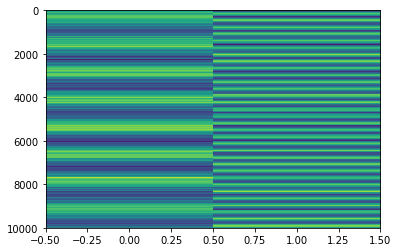

In [95]:
y_est = sfa_m.fit_transform(y)
plt.imshow(y_est, aspect='auto')
plt.show()

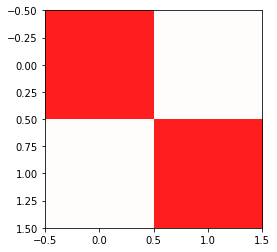

In [96]:
y_norm = y_est - y_est.mean(axis=0, keepdims=True)
y_norm /= np.linalg.norm(y_norm, axis=0, keepdims=True)
corr = y_norm.T.dot(x_norm)**2
plt.imshow(corr, vmin=-1, vmax=1, cmap='bwr')
plt.show()

In [97]:
corr

array([[0.88055819, 0.00833517],
       [0.00844457, 0.87847432]])